In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import zipfile
import shutil
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# grader-required-cell
from tensorflow.keras.optimizers import RMSprop

In [ ]:

# Set the path to the zip file
zip_file_path = '/content/drive/MyDrive/Dog_Datasets.zip'

# Set the destination folder for extraction
extract_folder = '/content'

# Create the destination folder if it doesn't exist
os.makedirs(extract_folder, exist_ok=True)

# Open the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all contents to the destination folder
    zip_ref.extractall(extract_folder)

print(f"Zip file '{zip_file_path}' extracted to '{extract_folder}'.")


Zip file '/content/drive/MyDrive/Dog_Datasets.zip' extracted to '/content'.


In [ ]:
# Storing the Labels in the file

# Specify the path to your main folder
main_folder_path = '/content/Dog_Datasets'

# Get a list of all items in the main folder
all_items = os.listdir(main_folder_path)

# Filter out only directories
subdirectories = [item for item in all_items if os.path.isdir(os.path.join(main_folder_path, item))]

# Now, subdirectories contains the names of all subdirectories in the main folder
print(subdirectories)


['n02106382-Bouvier_des_Flandres', 'n02097047-miniature_schnauzer', 'n02086910-papillon', 'n02099267-flat-coated_retriever', 'n02091244-Ibizan_hound', 'n02115641-dingo', 'n02091467-Norwegian_elkhound', 'n02101388-Brittany_spaniel', 'n02112018-Pomeranian', 'n02112137-chow', 'n02106030-collie', 'n02091032-Italian_greyhound', 'n02085936-Maltese_dog', 'n02102318-cocker_spaniel', 'n02109525-Saint_Bernard', 'n02090379-redbone', 'n02105505-komondor', 'n02094114-Norfolk_terrier', 'n02096051-Airedale', 'n02107142-Doberman', 'n02104029-kuvasz', 'n02110063-malamute', 'n02106662-German_shepherd', 'n02092002-Scottish_deerhound', 'n02098105-soft-coated_wheaten_terrier', 'n02113799-standard_poodle', 'n02107683-Bernese_mountain_dog', 'n02087394-Rhodesian_ridgeback', 'n02111889-Samoyed', 'n02108089-boxer', 'n02086079-Pekinese', 'n02093647-Bedlington_terrier', 'n02107908-Appenzeller', 'n02108000-EntleBucher', 'n02105162-malinois', 'n02100236-German_short-haired_pointer', 'n02112350-keeshond', 'n02095570

In [ ]:
# Set the paths
main_folder = '/content/Dog_Datasets'
data_dogs_folder = 'Data_dogs'
training_folder = os.path.join(data_dogs_folder, 'Training')
validation_folder = os.path.join(data_dogs_folder, 'Validation')

# Create the Data_dogs folder if it doesn't exist
if not os.path.exists(data_dogs_folder):
    os.makedirs(data_dogs_folder)

# Create Training and Validation folders if they don't exist
if not os.path.exists(training_folder):
    os.makedirs(training_folder)

if not os.path.exists(validation_folder):
    os.makedirs(validation_folder)

# Set the percentage split
validation_split = 0.1

# Iterate through each breed folder
for breed_folder in os.listdir(main_folder):
    breed_path = os.path.join(main_folder, breed_folder)

    if os.path.isdir(breed_path):
        # Create breed folders inside Training and Validation folders
        training_breed_path = os.path.join(training_folder, breed_folder)
        validation_breed_path = os.path.join(validation_folder, breed_folder)

        if not os.path.exists(training_breed_path):
            os.makedirs(training_breed_path)

        if not os.path.exists(validation_breed_path):
            os.makedirs(validation_breed_path)

        # Get the list of images for the breed
        images = os.listdir(breed_path)

        # Calculate the number of validation images based on the split
        num_validation = int(len(images) * validation_split)

        # Randomly shuffle the images
        random.shuffle(images)

        # Move images to Training and Validation folders
        for i, image in enumerate(images):
            src_path = os.path.join(breed_path, image)

            if i < num_validation:
                dest_path = os.path.join(validation_breed_path, image)
            else:
                dest_path = os.path.join(training_breed_path, image)

            shutil.copy(src_path, dest_path)

print("Dataset split into Training and Validation sets successfully.")


Dataset split into Training and Validation sets successfully.


In [135]:
# grader-required-cell

# GRADED FUNCTION: train_val_generators
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
  """
  Creates the training and validation data generators

  Args:
    TRAINING_DIR (string): directory path containing the training images
    VALIDATION_DIR (string): directory path containing the testing/validation images

  Returns:
    train_generator, validation_generator - tuple containing the generators
  """
  ### START CODE HERE

  # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
  train_datagen = ImageDataGenerator(rescale=1./255,
                                     rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True)

  # Pass in the appropriate arguments to the flow_from_directory method
  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=100,
                                                      class_mode='sparse',
                                                      target_size=(224,224))

  # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
  validation_datagen = ImageDataGenerator(rescale=1./255)

  # Pass in the appropriate arguments to the flow_from_directory method
  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=100,
                                                                class_mode='sparse',
                                                                target_size=(224,224))
  ### END CODE HERE
  return train_generator, validation_generator

In [136]:
train_dir="/content/Data_dogs/Training"
validation_dir="/content/Data_dogs/Validation"

In [137]:
# grader-required-cell

# Test your generators
train_generator, validation_generator = train_val_generators(train_dir, validation_dir)

Found 20380 images belonging to 120 classes.
Found 3818 images belonging to 120 classes.


In [138]:
def create_model():
    base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(weights="imagenet",include_top = False,
                                                     classes = 120)
    base_model.trainable = False

    inputs = layers.Input(shape = (224,224,3))
    x = base_model(inputs)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(512,activation='relu')(x)
    outputs = tf.keras.layers.Dense(120, activation= "softmax")(x)


    ModelDogBreed = tf.keras.Model(inputs, outputs)

    ModelDogBreed.compile(loss = "sparse_categorical_crossentropy",
                         optimizer = tf.keras.optimizers.Adam(),
                         metrics=["accuracy"])

    return ModelDogBreed

In [139]:
# Get the untrained model
model = create_model()
model.summary()
# Train the model
# Note that this may take some time.


Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_44 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, None, None, 1280   2257984   
 tional)                     )                                   
                                                                 
 global_average_pooling2d_2  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_19 (Dense)            (None, 512)               655872    
                                                                 
 dense_20 (Dense)            (None, 120)               61560     
                                                                 
Total params: 2975416 (11.35 MB)
Trainable params: 717432 (

In [140]:
history = model.fit(train_generator,
                    epochs=15,
                    verbose=1,
                    validation_data=validation_generator)

Epoch 1/15
204/204 [==============================] - 368s 1s/step - loss: 1.9589 - accuracy: 0.4981 - val_loss: 0.8410 - val_accuracy: 0.7559
Epoch 2/15
204/204 [==============================] - 306s 2s/step - loss: 1.3030 - accuracy: 0.6284 - val_loss: 0.7332 - val_accuracy: 0.7729
Epoch 3/15
204/204 [==============================] - 299s 1s/step - loss: 1.1709 - accuracy: 0.6580 - val_loss: 0.6379 - val_accuracy: 0.8002
Epoch 4/15
204/204 [==============================] - 300s 1s/step - loss: 1.1040 - accuracy: 0.6704 - val_loss: 0.6158 - val_accuracy: 0.8083
Epoch 5/15
204/204 [==============================] - 309s 2s/step - loss: 1.0317 - accuracy: 0.6935 - val_loss: 0.5569 - val_accuracy: 0.8250
Epoch 6/15
204/204 [==============================] - 305s 1s/step - loss: 0.9959 - accuracy: 0.7015 - val_loss: 0.5583 - val_accuracy: 0.8211
Epoch 7/15
204/204 [==============================] - 324s 2s/step - loss: 0.9488 - accuracy: 0.7173 - val_loss: 0.5076 - val_accuracy: 0.8376

In [ ]:
model.save('DOG_Breed')

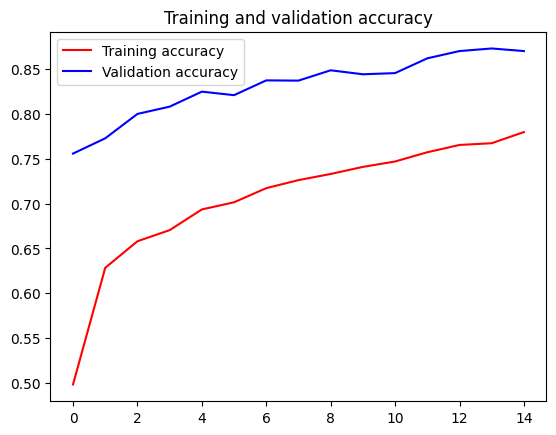

<Figure size 640x480 with 0 Axes>

In [143]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

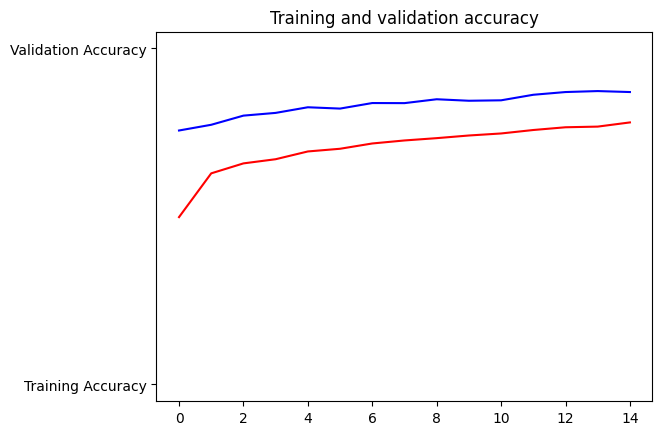

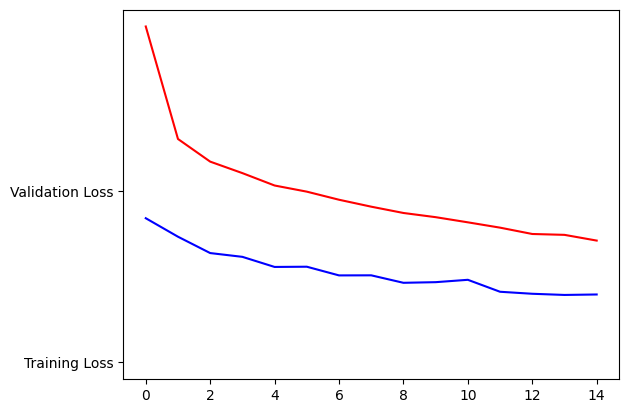

In [144]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.show()

In [4]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, None, None, 1280   2257984   
 tional)                     )                                   
                                                                 
 global_average_pooling (Gl  (None, 1280)              0         
 obalAveragePooling2D)                                           
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 120)               153720    
                                                                 
Total params: 2411704 (9.20 MB)
Trainable params: 153720 (600

In [145]:
labels=os.listdir('/content/Dog_Datasets')
breed_name=[]
for breed in labels:
  filtered_label= breed.split('-')[1]
  breed_name.append(filtered_label)
breed_name=np.array(breed_name)

Saving download (2).jpeg to download (2).jpeg
Saving download (1).jpeg to download (1).jpeg
1/1 [==============================] - 0s 22ms/step
The Pic Seems Like :  French_bulldog
1/1 [==============================] - 0s 21ms/step
The Pic Seems Like :  Welsh_springer_spaniel


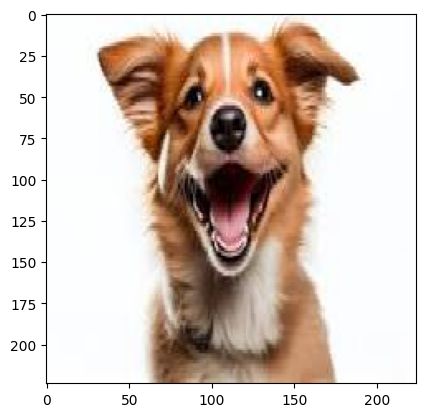

In [147]:
## NOTE: If you are using Safari and this cell throws an error,
## please skip this block and run the next one instead.

import numpy as np
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

uploaded = files.upload()

for fn in uploaded.keys():

  # predicting images
  path = fn
  img = load_img(path, target_size=(224,224))
  x = img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = loaded_model.predict(images, batch_size=10)
  import matplotlib.pyplot as plt
  plt.imshow(img)

  print('The Pic Seems Like : ',breed_name[np.argmax(classes-1)])

In [ ]:
# CODE BLOCK FOR OLDER VERSIONS OF SAFARI

import os
import numpy as np
from tensorflow.keras.utils import load_img, img_to_array

images = os.listdir("images")

print(images)

for i in images:
    print()
    # predicting images
    path = 'images/' + i
    img = load_img(path, target_size=(150, 150))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])
    classes = model.predict(images, batch_size=10)
    print(path)
    print(classes)

In [ ]:
# CODE BLOCK FOR OLDER VERSIONS OF SAFARI

import os
import numpy as np
from tensorflow.keras.utils import load_img, img_to_array

# images = os.listdir("/tmp/images")

# print(images)

# for i in images:
print()
# predicting images
path = 'd.jpeg' 
img = load_img(path, target_size=(150, 150))
x = img_to_array(img)
x = np.expand_dims(x, axis=0)
images = np.vstack([x])
classes = model.predict(img, batch_size=10)
print(path)
print(classes)